# Parameters

In [395]:
import matplotlib.pyplot as plt
import numpy as np

"""In order to provide a better presentation of the graphs we use the rcParams options shown below."""

import matplotlib
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['figure.figsize'] = (11.0, 8.0)

In [396]:
import time
from numba import jit


T0=time.time()

In [397]:
t_final=20

In [398]:
#Parameters

Theta=0
Phi=0


#Number of atoms

N=5

gr=1

DeltaR=10*gr*np.sqrt(N)*np.cos(Theta/2)

chiR=gr**2/(DeltaR)
chiL=0


fraction=0.6

OmegaR=fraction*N*((np.cos(Theta/2))**2)*gr**2/(DeltaR)
OmegaL=0
###   H=chiR*Z3M+chiL*Z2M+(OmegaR/2)*(Plus03M+Minus03M)+(OmegaL/2)*(Plus12M+Minus12M)

# Definition of Dicke-Generalized States

In [399]:
import numpy as np
from numpy import sqrt
import matplotlib.pyplot as plt


#--------------------------------------

State_List=[]

import scipy.special

#Number of generalized Dicke states

N_Dicke=int(scipy.special.binom(N+3, 3))

#Sparse matrix asscoiated with the hamiltonian in the generalized Dicke basis


Spar_Hamil_H1=np.zeros((N_Dicke,N_Dicke),complex)

In [400]:
import itertools
from itertools import permutations
from numba import jit


def List_Dicke(N=N):
    Gen_Dicke_List=[]

    for n0 in range(N):
        for n1 in range(N-n0):
            for n2 in range(N-n0-n1):
                Gen_Dicke_List.append([n0,n1,n2,N-n0-n1-n2])
            
    St_List=[]
    
    for j in Gen_Dicke_List:
        for k in list(permutations(j)):
            St_List.append(list(k))

    St_List.sort(reverse=True)
    Final_result=list(St_List for St_List,_ in itertools.groupby(St_List))
    return Final_result



List_results=List_Dicke(N)


Indexer_func=[1,N,N**2,N**3]

Index_state=[]


for j in List_results:
    Index_state.append([np.dot(j,Indexer_func),j])

Index_state.sort()

Index_States_final=[]


States_sorted=[]


for j in range(len(Index_state)):
    Rep_column=np.zeros((N_Dicke,1))
    Rep_column[j,0]=1
    Index_States_final.append([j,Index_state[j][1],Rep_column])
    States_sorted.append(Index_state[j][1])
    

In [401]:
from scipy.integrate import complex_ode

"""Our system of differential equations belongs to the complex space, that is why we implemented the code suggested in"""
"""https://stackoverflow.com/questions/19910189/scipy-odeint-with-complex-initial-values."""

import time
import numpy as np
from scipy.integrate import odeint


def odeintz(func, z0, t, **kwargs):
   
    
    """An odeint-like function for complex valued differential equations.

    Inputs:
    ----------
      -func: function associated to dr/dt=f(x;t), where x is the set of parameters and variables to be determined
      -z0: 1d array with length N*(5N-1)/2
      -t: 1d array from t=0 to t=tf (parameter set by the user)
      - **kwargs: keyword arguments related with external functions to be used in odeint
    
    Return:
      -z: multivariable array with the solution of the differential equation associated with each variable"""

    
    
    

    # Disallow Jacobian-related arguments.
    _unsupported_odeint_args = ['Dfun', 'col_deriv', 'ml', 'mu']
    bad_args = [arg for arg in kwargs if arg in _unsupported_odeint_args]
    if len(bad_args) > 0:
        raise ValueError("The odeint argument %r is not supported by "
                         "odeintz." % (bad_args[0],))

    # Make sure z0 is a numpy array of type np.complex128.
    z0 = np.array(z0, dtype=np.complex128, ndmin=1)

    def realfunc(x, t, *args):
        z = x.view(np.complex128)
        dzdt = func(z, t, *args)
        # func might return a python list, so convert its return
        # value to an array with type np.complex128, and then return
        # a np.float64 view of that array.
        return np.asarray(dzdt, dtype=np.complex128).view(np.float64)

    result = odeint(realfunc, z0.view(np.float64), t, **kwargs)

    if kwargs.get('full_output', False):
        z = result[0].view(np.complex128)
        infodict = result[1]
        return z, infodict
    else:
        z = result.view(np.complex128)
        return z

## Description of operators

In [402]:
def dagger(A):
    return np.transpose(np.conjugate(A))

### $R^+=\sum_i   \left| 3 \right>\!\!\left< 0 \right|_i$

In [403]:
# H_2=\omega_R*R_x+\omega_L*L_x


Spar_Hamil_Plus03=np.zeros((N_Dicke,N_Dicke),complex)


def Plus03(State_rep):
    
    n0=State_rep[0]
    n1=State_rep[1]
    n2=State_rep[2]
    n3=N-n2-n1-n0
    
    Plus03_state=np.zeros((N_Dicke,1))
    

    if n0!=0 and n3!=N:
        index=States_sorted.index([n0-1,n1,n2,n3+1])
        Vecto_Rep=np.array(Index_States_final[index][2])
        Plus03_state=Plus03_state+sqrt(n0*(n3+1))*Vecto_Rep
              
    
    return Plus03_state


t0=time.time()


def fun03M():
    for i in range(N_Dicke):
        for j in range(N_Dicke):
            Spar_Hamil_Plus03[i][j]=np.dot(np.transpose(Index_States_final[i][2]),Plus03(States_sorted[j]))[0][0]
    return Spar_Hamil_Plus03
        
t1=time.time()

Plus03M=fun03M()
Minus03M=dagger(Plus03M)

print(t1-t0)


0.0


### $L^+=\sum_i   \left| 2 \right>\!\!\left< 1 \right|_i$

In [404]:
# H_2=\omega_R*R_x+\omega_L*L_x


Spar_Hamil_Plus12=np.zeros((N_Dicke,N_Dicke),complex)

def Plus12(State_rep):
    
    n0=State_rep[0]
    n1=State_rep[1]
    n2=State_rep[2]
    n3=N-n2-n1-n0
    
    Plus12_state=np.zeros((N_Dicke,1))
    
    
    if n1!=0 and n2!=N:
        index=States_sorted.index([n0,n1-1,n2+1,n3])
        Vecto_Rep=np.array(Index_States_final[index][2])
        Plus12_state=Plus12_state+sqrt(n1*(n2+1))*Vecto_Rep
    

    
    return Plus12_state


t0=time.time()

for i in range(N_Dicke):
    for j in range(N_Dicke):
        Spar_Hamil_Plus12[i][j]=np.dot(np.transpose(Index_States_final[i][2]),Plus12(States_sorted[j]))[0][0]
        
        
t1=time.time()

print(t1-t0)


Plus12M=Spar_Hamil_Plus12


Minus12M=dagger(Plus12M)

0.028002262115478516


## $G^+=\sum_i   \left| 1 \right>\!\!\left< 0 \right|_i$

In [405]:

Spar_Hamil_Plus01=np.zeros((N_Dicke,N_Dicke),complex)

def Plus01(State_rep):
    
    n0=State_rep[0]
    n1=State_rep[1]
    n2=State_rep[2]
    n3=N-n2-n1-n0
    
    Plus01_state=np.zeros((N_Dicke,1))
    
    
    if n0!=0 and n1!=N:
        index=States_sorted.index([n0-1,n1+1,n2,n3])
        Vecto_Rep=np.array(Index_States_final[index][2])
        Plus01_state=Plus01_state+sqrt(n0*(n1+1))*Vecto_Rep
    

    
    return Plus01_state


t0=time.time()

for i in range(N_Dicke):
    for j in range(N_Dicke):
        Spar_Hamil_Plus01[i][j]=np.dot(np.transpose(Index_States_final[i][2]),Plus01(States_sorted[j]))[0][0]
        
        
t1=time.time()

print(t1-t0)


Plus01M=Spar_Hamil_Plus01

Minus01M=dagger(Plus01M)

0.038038015365600586


## $E^+=\sum_i   \left| 3 \right>\!\!\left< 2 \right|_i$

In [406]:

Spar_Hamil_Plus23=np.zeros((N_Dicke,N_Dicke),complex)

def Plus23(State_rep):
    
    n0=State_rep[0]
    n1=State_rep[1]
    n2=State_rep[2]
    n3=N-n2-n1-n0
    
    Plus23_state=np.zeros((N_Dicke,1))
    
    
    if n2!=0 and n3!=N:
        index=States_sorted.index([n0,n1,n2-1,n3+1])
        Vecto_Rep=np.array(Index_States_final[index][2])
        Plus23_state=Plus23_state+sqrt(n2*(n3+1))*Vecto_Rep
    

    
    return Plus23_state


t0=time.time()

for i in range(N_Dicke):
    for j in range(N_Dicke):
        Spar_Hamil_Plus23[i][j]=np.dot(np.transpose(Index_States_final[i][2]),Plus23(States_sorted[j]))[0][0]
        
        
t1=time.time()

print(t1-t0)


Plus23M=Spar_Hamil_Plus23

Minus23M=dagger(Plus23M)

0.03224515914916992


## $M^+=\sum_i   \left| 2 \right>\!\!\left< 0 \right|_i$

In [407]:

Spar_Hamil_Plus02=np.zeros((N_Dicke,N_Dicke),complex)

def Plus02(State_rep):
    
    n0=State_rep[0]
    n1=State_rep[1]
    n2=State_rep[2]
    n3=N-n2-n1-n0
    
    Plus02_state=np.zeros((N_Dicke,1))
    
    
    if n0!=0 and n2!=N:
        index=States_sorted.index([n0-1,n1,n2+1,n3])
        Vecto_Rep=np.array(Index_States_final[index][2])
        Plus02_state=Plus02_state+sqrt(n0*(n2+1))*Vecto_Rep
    

    
    return Plus02_state


t0=time.time()

for i in range(N_Dicke):
    for j in range(N_Dicke):
        Spar_Hamil_Plus02[i][j]=np.dot(np.transpose(Index_States_final[i][2]),Plus02(States_sorted[j]))[0][0]
        
        
t1=time.time()

print(t1-t0)


Plus02M=Spar_Hamil_Plus02
Minus02M=dagger(Plus02M)

0.03427863121032715


## $P^+=\sum_i   \left| 3 \right>\!\!\left< 1 \right|_i$

In [408]:

Spar_Hamil_Plus13=np.zeros((N_Dicke,N_Dicke),complex)

def Plus13(State_rep):
    
    n0=State_rep[0]
    n1=State_rep[1]
    n2=State_rep[2]
    n3=N-n2-n1-n0
    
    Plus13_state=np.zeros((N_Dicke,1))
    
    
    if n1!=0 and n3!=N:
        index=States_sorted.index([n0,n1-1,n2,n3+1])
        Vecto_Rep=np.array(Index_States_final[index][2])
        Plus13_state=Plus13_state+sqrt(n1*(n3+1))*Vecto_Rep
    

    
    return Plus13_state


t0=time.time()

for i in range(N_Dicke):
    for j in range(N_Dicke):
        Spar_Hamil_Plus13[i][j]=np.dot(np.transpose(Index_States_final[i][2]),Plus13(States_sorted[j]))[0][0]
        
        
t1=time.time()

print(t1-t0)


Plus13M=Spar_Hamil_Plus13
Minus13M=dagger(Plus13M)

0.03103041648864746


In [409]:

Spar_Hamil_Z3=np.zeros((N_Dicke,N_Dicke),complex)

def Z3(State_rep):
    
    n0=State_rep[0]
    n1=State_rep[1]
    n2=State_rep[2]
    n3=N-n2-n1-n0
    
    Z3_state=np.zeros((N_Dicke,1))
    
    
    if n1!=-1 and n3!=-1:
        index=States_sorted.index([n0,n1,n2,n3])
        Vecto_Rep=np.array(Index_States_final[index][2])
        Z3_state=Z3_state+n3*(n0+1)*Vecto_Rep
    

    
    return Z3_state


t0=time.time()

for i in range(N_Dicke):
    for j in range(N_Dicke):
        Spar_Hamil_Z3[i][j]=np.dot(np.transpose(Index_States_final[i][2]),Z3(States_sorted[j]))[0][0]
        
        
t1=time.time()

print(t1-t0)


Z3M=Spar_Hamil_Z3

0.02799820899963379


In [410]:

Spar_Hamil_Z2=np.zeros((N_Dicke,N_Dicke),complex)

def Z2(State_rep):
    
    n0=State_rep[0]
    n1=State_rep[1]
    n2=State_rep[2]
    n3=N-n2-n1-n0


    index=States_sorted.index([n0,n1,n2,n3])
    Vecto_Rep=np.array(Index_States_final[index][2])
    

    
    return n2*(n1+1)*Vecto_Rep


t0=time.time()

for i in range(N_Dicke):
    for j in range(N_Dicke):
        Spar_Hamil_Z2[i][j]=np.dot(np.transpose(Index_States_final[i][2]),Z2(States_sorted[j]))[0][0]
        
        
t1=time.time()

print(t1-t0)


Z2M=Spar_Hamil_Z2

0.03200364112854004


In [411]:
import numpy as np
import matplotlib.pyplot as plt
""""
plt.imshow(np.real(Z2M))
plt.colorbar()
plt.show()

"""

'"\nplt.imshow(np.real(Z2M))\nplt.colorbar()\nplt.show()\n\n'

In [412]:

Spar_Hamil_00=np.zeros((N_Dicke,N_Dicke),complex)

def Z00(State_rep):
    
    n0=State_rep[0]
    n1=State_rep[1]
    n2=State_rep[2]
    n3=N-n2-n1-n0
    

    index=States_sorted.index([n0,n1,n2,n3])
    Vecto_Rep=np.array(Index_States_final[index][2])
    Z00_state=(n0)*Vecto_Rep
    

    
    return Z00_state


t0=time.time()

for i in range(N_Dicke):
    for j in range(N_Dicke):
        Spar_Hamil_00[i][j]=np.dot(np.transpose(Index_States_final[i][2]),Z00(States_sorted[j]))[0][0]
        
        
t1=time.time()

print(t1-t0)






Spar_Hamil_11=np.zeros((N_Dicke,N_Dicke),complex)

def Z11(State_rep):
    
    n0=State_rep[0]
    n1=State_rep[1]
    n2=State_rep[2]
    n3=N-n2-n1-n0
    

    index=States_sorted.index([n0,n1,n2,n3])
    Vecto_Rep=np.array(Index_States_final[index][2])
    Z11_state=(n1)*Vecto_Rep
    

    
    return Z11_state


t0=time.time()

for i in range(N_Dicke):
    for j in range(N_Dicke):
        Spar_Hamil_11[i][j]=np.dot(np.transpose(Index_States_final[i][2]),Z11(States_sorted[j]))[0][0]
        
        
t1=time.time()

print(t1-t0)





Spar_Hamil_22=np.zeros((N_Dicke,N_Dicke),complex)

def Z22(State_rep):
    
    n0=State_rep[0]
    n1=State_rep[1]
    n2=State_rep[2]
    n3=N-n2-n1-n0
    

    index=States_sorted.index([n0,n1,n2,n3])
    Vecto_Rep=np.array(Index_States_final[index][2])
    Z22_state=(n2)*Vecto_Rep
    

    
    return Z22_state


t0=time.time()

for i in range(N_Dicke):
    for j in range(N_Dicke):
        Spar_Hamil_22[i][j]=np.dot(np.transpose(Index_States_final[i][2]),Z22(States_sorted[j]))[0][0]
        
        
t1=time.time()

print(t1-t0)








Spar_Hamil_33=np.zeros((N_Dicke,N_Dicke),complex)

def Z33(State_rep):
    
    n0=State_rep[0]
    n1=State_rep[1]
    n2=State_rep[2]
    n3=N-n2-n1-n0
    

    index=States_sorted.index([n0,n1,n2,n3])
    Vecto_Rep=np.array(Index_States_final[index][2])
    Z33_state=(n3)*Vecto_Rep
    

    
    return Z33_state


t0=time.time()

for i in range(N_Dicke):
    for j in range(N_Dicke):
        Spar_Hamil_33[i][j]=np.dot(np.transpose(Index_States_final[i][2]),Z33(States_sorted[j]))[0][0]
        
        
t1=time.time()

print(t1-t0)

Z00=Spar_Hamil_00
Z11=Spar_Hamil_11
Z22=Spar_Hamil_22
Z33=Spar_Hamil_33



0.028968334197998047
0.02500128746032715
0.03459024429321289
0.026042461395263672


# Hamiltonian

In [413]:
H=chiR*Z3M+chiL*Z2M+(OmegaR/2)*(Plus03M+Minus03M)+(OmegaL/2)*(Plus12M+Minus12M)

## Initial State $\left|\psi\left(0\right) \right>=\left(  \cos\left(\frac{\theta}{2}\right)\left|0 \right>+\rm{exp}\left(\rm{i}\phi \right) \sin\left(\frac{\theta}{2}\right)\left|1 \right> \right)^{\otimes N}$

In [414]:


from numpy import sin, cos, exp

Psi_init=np.zeros((N_Dicke,1),complex)

for j in range(N+1):
    Psi_init[j][0]=((cos(Theta/2))**(N-j))*((sin(Theta/2)*exp(1j*Phi))**j)*sqrt(int(scipy.special.binom(N, j)))    

## Solve $\partial_t \left|\psi  \right>=$ $-\rm{i}$$H\left|\psi  \right>$

In [415]:
#H=Spar_Hamil_H1+Spar_Hamil_H2
import matplotlib

In [416]:
Psi_init_list=[]

for j in Psi_init:
    Psi_init_list.append(j[0])

In [417]:
from numba import jit

#@jit

def vectors2(r, t, extern, linear_matrix,N=N):
    
    
    """Obtains the vector which summarizes the linear and non-linear elements of the differential matrix wrriten of the form
    dr/dt=G(r,t).r, where the matrix G depends of the vector that we want to simulate
    
    Inputs:
    ----------
      -r: zeroth index
      -t: first index
      -extern: index for the zz element
      -linear_matrix:
    
    Returns:
      -drdt: vector function with the different contributions from linear and non-linear terms that we require to initialize
      odeintz"""
    
    
    
    s = linear_matrix @ r  #Vector multiplication
    drdt = s  #sum of the linear and the constant part
    
    return drdt

In [418]:
def sol_vector(steps,t_final):
    linear_matrix = -1j*H
    extern=0
    t = np.linspace(0, t_final, steps)
    r = odeintz(vectors2, Psi_init_list, t, args=(extern,linear_matrix))
    return r
    

In [419]:
import time 

t0=time.time()

steps=20000


Array_sol=sol_vector(steps,t_final)


t1=time.time()

print(t1-t0)


0.026003599166870117


In [420]:
t = np.linspace(0, t_final, steps)


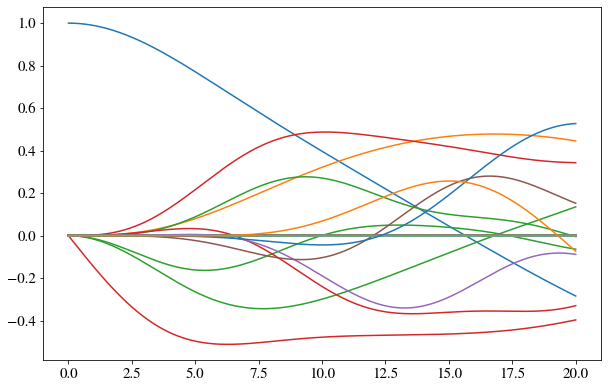

In [421]:
matplotlib.rcParams['figure.figsize'] = (10.0, 6.5)

label_size = 20

for j in range(N_Dicke):
    plt.plot(t,np.real(Array_sol[:,j]))
    plt.plot(t,np.imag(Array_sol[:,j]))

In [422]:
Op01x=0.5*(Plus01M+Minus01M)
Op02x=0.5*(Plus02M+Minus02M)
Op03x=0.5*(Plus03M+Minus03M)
Op12x=0.5*(Plus12M+Minus12M)
Op13x=0.5*(Plus13M+Minus13M)
Op23x=0.5*(Plus23M+Minus23M)

Op01y=0.5*(Plus01M-Minus01M)/(1j)
Op02y=0.5*(Plus02M-Minus02M)/(1j)
Op03y=0.5*(Plus03M-Minus03M)/(1j)
Op12y=0.5*(Plus12M-Minus12M)/(1j)
Op13y=0.5*(Plus13M-Minus13M)/(1j)
Op23y=0.5*(Plus23M-Minus23M)/(1j)



List_X=[Op01x,Op02x,Op03x,Op12x,Op13x,Op23x]
List_Y=[Op01y,Op02y,Op03y,Op12y,Op13y,Op23y]
List_Z=[Z00,Z11,Z22,Z33]


@jit

def expect_op(Operator):
    Expect_operator=[]

    for j in range(len(t)):
        Expect_operator.append(np.dot(np.conjugate(Array_sol[j]),np.dot(Operator,Array_sol[j])))
    
    return np.real(Expect_operator)    # We assume that we will use inly hermitian operators


<ipython-input-422-415362e4f5f4>:22: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "expect_op" failed type inference due to: No implementation of function Function(<function real at 0x0000015290620310>) found for signature:
 
 >>> real(list(complex128))
 
There are 2 candidate implementations:
      - Of which 2 did not match due to:
      Overload in function 'np_real': File: numba\np\arraymath.py: Line 3287.
        With argument(s): '(list(complex128))':
       Rejected as the implementation raised a specific error:
         TypingError: Failed in nopython mode pipeline (step: nopython frontend)
       Unknown attribute 'real' of type list(complex128)
       
       File "..\..\..\anaconda3\lib\site-packages\numba\np\arraymath.py", line 3290:
           def np_real_impl(a):
               return a.real
               ^
       
       During: typing of get attribute at C:\Users\camil\anaconda3\lib\site-packages\numba\np\arraymath.

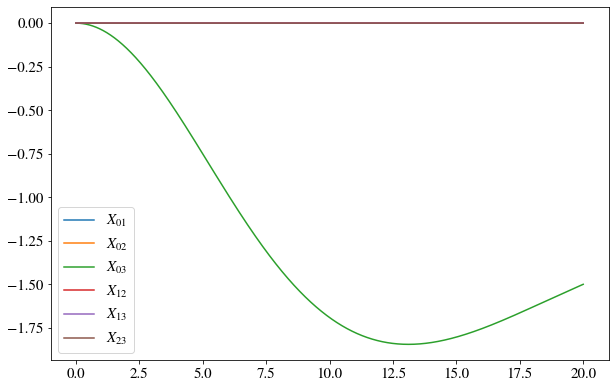

In [423]:
plt.plot(t,expect_op(List_X[0]),label='$X_{01}$')
plt.plot(t,expect_op(List_X[1]),label='$X_{02}$')
plt.plot(t,expect_op(List_X[2]),label='$X_{03}$')
plt.plot(t,expect_op(List_X[3]),label='$X_{12}$')
plt.plot(t,expect_op(List_X[4]),label='$X_{13}$')
plt.plot(t,expect_op(List_X[5]),label='$X_{23}$')


plt.legend()

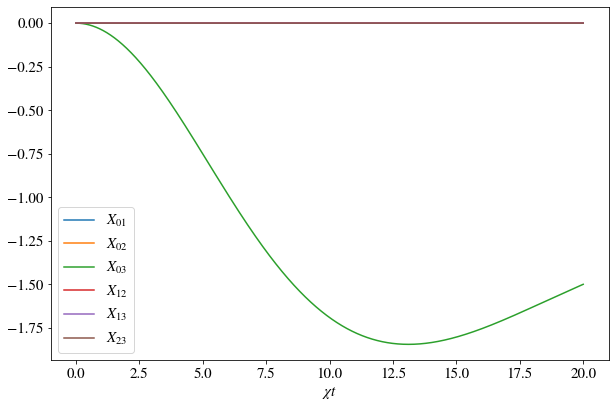

In [424]:
plt.plot(t,expect_op(List_X[0]),label='$X_{01}$')
plt.plot(t,expect_op(List_X[1]),label='$X_{02}$')
plt.plot(t,expect_op(List_X[2]),label='$X_{03}$')
plt.plot(t,expect_op(List_X[3]),label='$X_{12}$')
plt.plot(t,expect_op(List_X[4]),label='$X_{13}$')
plt.plot(t,expect_op(List_X[5]),label='$X_{23}$')


plt.xlabel("$\chi t$")
plt.legend()

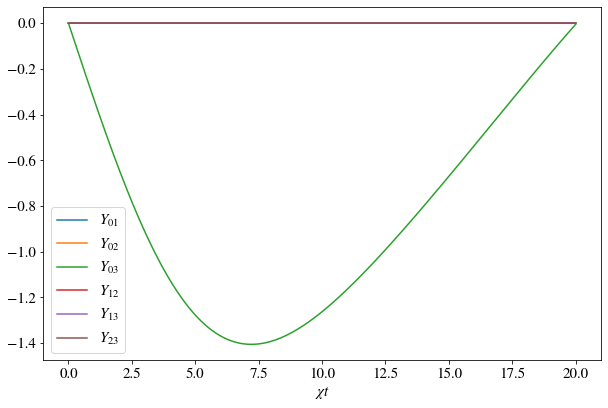

In [425]:
plt.plot(t,expect_op(List_Y[0]),label='$Y_{01}$')
plt.plot(t,expect_op(List_Y[1]),label='$Y_{02}$')
plt.plot(t,expect_op(-List_Y[2]),label='$Y_{03}$')
plt.plot(t,expect_op(List_Y[3]),label='$Y_{12}$')
plt.plot(t,expect_op(List_Y[4]),label='$Y_{13}$')
plt.plot(t,expect_op(List_Y[5]),label='$Y_{23}$')


plt.xlabel("$\chi t$")

plt.legend()

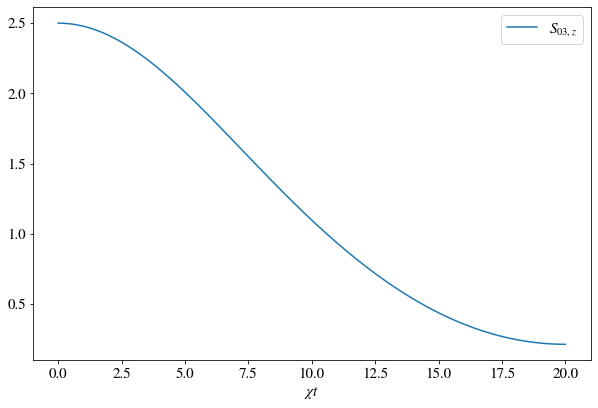

In [426]:
plt.plot(t,0.5*(expect_op(List_Z[0])-expect_op(List_Z[3])),label='$S_{03,z}$')

plt.xlabel("$\chi t$")

plt.legend()

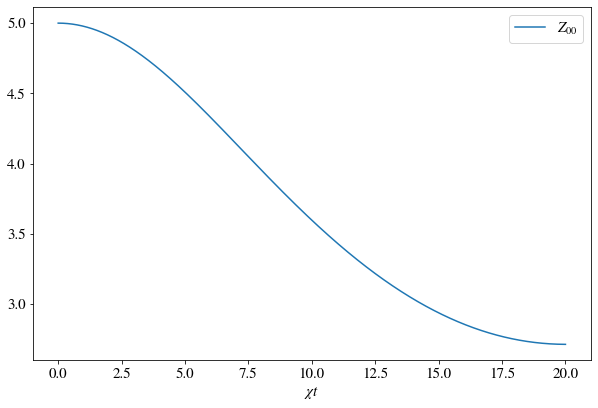

In [427]:
plt.plot(t,expect_op(List_Z[0]),label='$Z_{00}$')
#plt.plot(t,expect_op(List_Z[1]),label='$Z_{11}$')
#plt.plot(t,expect_op(List_Z[2]),label='$Z_{22}$')
#plt.plot(t,expect_op(List_Z[3]),label='$Z_{33}$')


plt.xlabel("$\chi t$")

plt.legend()

In [428]:
N

5

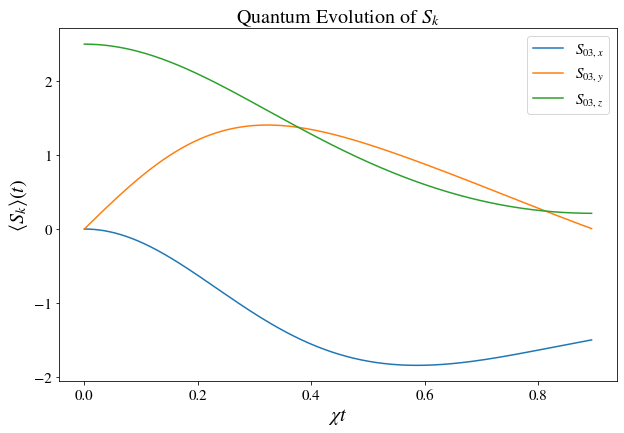

In [429]:
matplotlib.rcParams['figure.figsize'] = (10.0, 6.5)

fig3 = plt.figure(3)
plt.title(r'Quantum Evolution of $S_k$', fontsize = label_size)
plt.xlabel(r'$gt$', fontsize = label_size)
#plt.ylabel(r'$\langle a^\dagger a\rangle(t)$', fontsize = label_size)
plt.ylabel(r'$\langle S_k \rangle(t)$', fontsize = label_size)

def partit(number,array):
    j=0
    dis=len(array)
    result=[]
    while j*number<dis:
        result.append(array[j*number])
        j=j+1
    return result

reductor=10


plt.plot(partit(reductor,t*gr**2/(DeltaR)),partit(reductor,expect_op(List_X[2])),label='$S_{03,x}$')
plt.plot(partit(reductor,t*gr**2/(DeltaR)),partit(reductor,expect_op(List_Y[2])),label='$S_{03,y}$')
plt.plot(partit(reductor,t*gr**2/(DeltaR)),partit(reductor,0.5*(expect_op(List_Z[0])-expect_op(List_Z[3]))),label='$S_{03,z}$')


plt.xlabel("$\chi t$")
plt.legend()

In [430]:
import matplotlib.pyplot as plt
from numpy import linalg as LA
import scipy.special

import time
from scipy.integrate import odeint
from scipy.special import zeta
from random import choices

In [431]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import numpy as np


from qutip import *
from qutip.piqs import *

import matplotlib.animation as animation
from IPython.display import HTML
from IPython.core.display import Image, display

In [432]:
J=1
    
refg    = 1
refdelta= DeltaR
refkappa= 0

refomega= OmegaR
refgamma= 0

    
Omega =refomega*J
g_coef=refg*J
Delta=refdelta*J
kappa=refkappa*J
Gamma_phi=refgamma*J
    

Gamma_du=0  #Fixed



## PIQS Spin-model

In [433]:
# TLS parameters
n_tls = N
system = Dicke(N = n_tls)
[jx, jy, jz] = jspin(N)
jp = jspin(N,"+")
jm = jp.dag()

system.hamiltonian = OmegaR* jx+chiR*jp*jm
system.collective_dephasing = 2*Gamma_phi
D_tls = system.liouvillian() 



# Light-matter coupling parameters

kappa_eff=2*kappa


nphot = int(2*N+2)  #modes of light
a = destroy(nphot)
h_int = 0*(tensor(a, jp)+tensor(a.dag(), jm))



# Photonic Liouvillian
c_ops_phot = [np.sqrt(kappa_eff) * a]

D_phot = liouvillian(Delta * a.dag()*a , c_ops_phot)

# Identity super-operators
nds = num_dicke_states(n_tls)
id_tls = to_super(qeye(nds))
id_phot = to_super(qeye(nphot))

# Define the total Liouvillian
D_int = -1j* spre(h_int) + 1j* spost(h_int)
D_tot = D_int + super_tensor(D_phot, id_tls) + super_tensor(id_phot, D_tls)

# Define operator in the total space
nphot_tot = tensor(a.dag()*a, qeye(nds))
adag_cuad_a_cuad = tensor(a.dag()*a.dag()*a*a, qeye(nds))

jx_tot=tensor(qeye(nphot), jx)
jy_tot=tensor(qeye(nphot), jy)
jz_tot=tensor(qeye(nphot), jz)

jxcuad_tot=tensor(qeye(nphot), jx*jx)
jycuad_tot=tensor(qeye(nphot), jy*jy)
jzcuad_tot=tensor(qeye(nphot), jz*jz)


In [434]:
theta=Theta
phi=0

excited_state = excited(N)
ground_state = dicke(N, N/2, -N/2)

ground_phot = ket2dm(basis(nphot,0))  #vacuum
#rho0 = tensor(ground_phot, excited_state)
#rho0 = tensor(ground_phot, ground_state)



import scipy.special

rho_init=np.array(ground_state)


for n in range(N+1):
    for npr in range(N+1):
        sq_bin=np.sqrt(scipy.special.binom(N,n)*scipy.special.binom(N,npr))
        p_cos=np.power(np.cos(theta/2),n+npr)
        p_sin=np.power(np.sin(theta/2),2*N-n-npr)
        p_phi=np.exp(1j*phi*(npr-n))
        rho_init[n][npr]=sq_bin*p_cos*p_sin*p_phi

rho0=   tensor(ground_phot, Qobj(rho_init))     

In [435]:
tT = np.linspace(0, t_final, 10000)
result1 = mesolve(D_tot, rho0, tT, [], e_ops = [nphot_tot,jx_tot,jy_tot,jz_tot,adag_cuad_a_cuad,jxcuad_tot,jycuad_tot,jzcuad_tot], 
                  options = Options(store_states=True))    #[nphot_tot,jx,jy,jz]
rhot_tot = result1.states
nphot_t = result1.expect[0]
jx_t = result1.expect[1]
jy_t = result1.expect[2]
jz_t = result1.expect[3]
adag_cuad_a_cuad_t=result1.expect[4]
jxx_t=result1.expect[5]
jyy_t=result1.expect[6]
jzz_t=result1.expect[7]

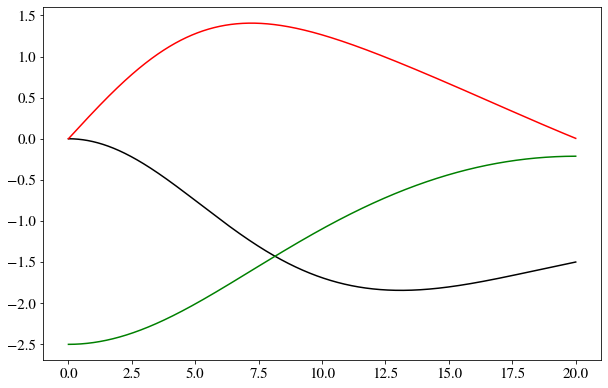

In [436]:
plt.plot(tT, jx_t, 'k-', label='$S_X$ PIQS')
plt.plot(tT, jy_t, 'r-', label='$S_y$ PIQS')
plt.plot(tT, jz_t, 'g-', label='$S_z$ PIQS')

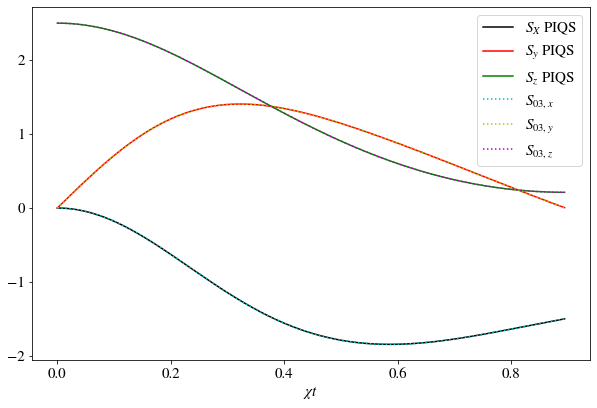

In [437]:
plt.plot(tT*gr**2/(DeltaR), jx_t, 'k-', label='$S_X$ PIQS')
plt.plot(tT*gr**2/(DeltaR), jy_t, 'r-', label='$S_y$ PIQS')
plt.plot(tT*gr**2/(DeltaR), -jz_t, 'g-', label='$S_z$ PIQS')

plt.plot(t*gr**2/(DeltaR),expect_op(List_X[2]),'c:',label='$S_{03,x}$')
plt.plot(t*gr**2/(DeltaR),expect_op(List_Y[2]),'y:',label='$S_{03,y}$')
plt.plot(t*gr**2/(DeltaR),0.5*(expect_op(List_Z[0])-expect_op(List_Z[3])),'m:',label='$S_{03,z}$')
plt.xlabel("$\chi t$")

plt.legend()

## PIQS Cavity-Spin model

In [438]:
systemc = Dicke(N = n_tls)

systemc.hamiltonian = Omega* jx
D_tlsc = systemc.liouvillian() 



# Light-matter coupling parameters

nphot = int(2*N+2)  #modes of light
a = destroy(nphot)
h_intc = g_coef*( tensor(a, jp)+tensor(a.dag(), jm) )



# Photonic Liouvillian
c_ops_phot = [np.sqrt(kappa_eff) * a]

D_photc = liouvillian(-Delta * a.dag()*a , c_ops_phot)

# Identity super-operators
nds = num_dicke_states(n_tls)
id_tls = to_super(qeye(nds))
id_phot = to_super(qeye(nphot))

# Define the total Liouvillian
D_intc = -1j* spre(h_intc) + 1j* spost(h_intc)
D_totc = D_intc + super_tensor(D_photc, id_tls) + super_tensor(id_phot, D_tlsc)

# Define operator in the total space
nphot_tot = tensor(a.dag()*a, qeye(nds))
adag_cuad_a_cuad = tensor(a.dag()*a.dag()*a*a, qeye(nds))

jx_tot=tensor(qeye(nphot), jx)
jy_tot=tensor(qeye(nphot), jy)
jz_tot=tensor(qeye(nphot), jz)

jxcuad_tot=tensor(qeye(nphot), jx*jx)
jycuad_tot=tensor(qeye(nphot), jy*jy)
jzcuad_tot=tensor(qeye(nphot), jz*jz)


In [439]:
print(t2[-1],tT[-1])

200.0 20.0


In [440]:
t2 = np.linspace(0, t_final, 5000)
result2 = mesolve(D_totc, rho0, t2, [], e_ops = [nphot_tot,jx_tot,jy_tot,jz_tot,adag_cuad_a_cuad,jxcuad_tot,jycuad_tot,jzcuad_tot], 
                  options = Options(store_states=True))    #[nphot_tot,jx,jy,jz]
rhot_tot = result2.states
nphot_t = result2.expect[0]
jx_t2 = result2.expect[1]
jy_t2 = result2.expect[2]
jz_t2 = result2.expect[3]
adag_cuad_a_cuad_t2=result2.expect[4]
jxx_t2=result2.expect[5]
jyy_t2=result2.expect[6]
jzz_t2=result2.expect[7]

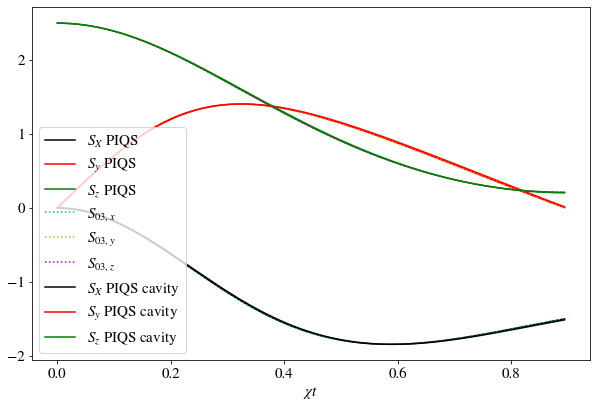

In [441]:
plt.plot(tT*gr**2/(DeltaR), jx_t, 'k-', label='$S_X$ PIQS')
plt.plot(tT*gr**2/(DeltaR), jy_t, 'r-', label='$S_y$ PIQS')
plt.plot(tT*gr**2/(DeltaR), -jz_t, 'g-', label='$S_z$ PIQS')

plt.plot(t*gr**2/(DeltaR),expect_op(List_X[2]),'c:',label='$S_{03,x}$')
plt.plot(t*gr**2/(DeltaR),expect_op(List_Y[2]),'y:',label='$S_{03,y}$')
plt.plot(t*gr**2/(DeltaR),0.5*(expect_op(List_Z[0])-expect_op(List_Z[3])),'m:',label='$S_{03,z}$')

plt.plot(t2*gr**2/(DeltaR), jx_t2, 'k-', label='$S_X$ PIQS cavity')
plt.plot(t2*gr**2/(DeltaR), jy_t2, 'r-', label='$S_y$ PIQS cavity')
plt.plot(t2*gr**2/(DeltaR), -jz_t2, 'g-', label='$S_z$ PIQS cavity')

plt.xlabel("$\chi t$")
plt.legend()
